In [1]:
# notebook for visualizing plane MILP results

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import clear_output

In [2]:
x = 10e-9
s = (1 + x**2)**(1/2) - 1
print(s)
s1 = x**2 / ((1 + x**2)**(1/2) + 1)
print(s1)

0.0
5.0000000000000005e-17


In [3]:
!python3 ./z-python-scripts/prepare_data.py ./files/plane.lp
!./Cutting_Plane_Generators "./files/data.txt"
!python3 ./z-python-scripts/write_cuts_in_lp.py ./files/cuts.txt ./files/plane.lp

./files/plane.lp
original problem has 2 variables (0 bin, 2 int, 0 impl, 0 cont) and 2 constraints
wrote problem to file /mnt/d/dev/Cutting-Plane-Generators/files/plane.mps
./files/data.txt
Nothing happens
-5.93496(0, 0.219512)(1, -1.05691) len=2

-0.227642(1, -0.0325203) len=2

GMI1 generated: 2
Message!
./files/cuts.txt ./files/plane.lp
original problem has 2 variables (0 bin, 2 int, 0 impl, 0 cont) and 2 constraints


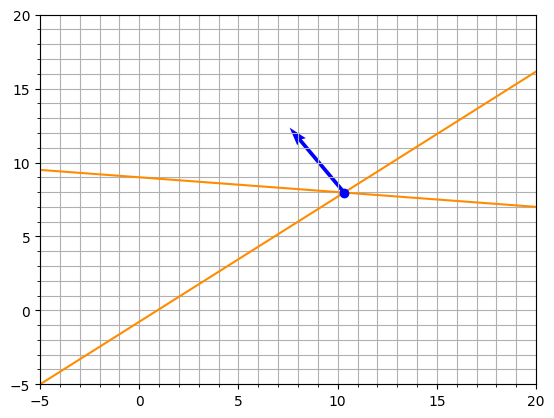

In [4]:
from pysmps import smps_loader as mps
from pyscipopt import LP


signs = mps.load_mps("./files/plane.mps")[5]
obj = mps.load_mps("./files/plane.mps")[6]
a_matrix = mps.load_mps("./files/plane.mps")[7]
rhs = mps.load_mps("./files/plane.mps")[9]['RHS']

constraints = zip(signs, a_matrix, rhs)

x = np.array([-10 + 0.1 * i for i in range(0, 1001)])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.grid(which='both', clip_on=False)
ax.set_ylim(-5, 20)
ax.set_xlim(-5, 20)

major_ticks = np.arange(-5, 21, 5)
minor_ticks = np.arange(-4, 21, 1)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

for sign, row, rhs in constraints:
    
    if row[1] != 0:
        y = (rhs - row[0] * x) / row[1]
    else:
        y = np.array([-10 + 0.1 * i for i in range(0, 1001)])
        x = np.ones(len(y)) * rhs / row[0]
    ax.plot(x, y, 'darkorange')

lp = LP()
lp.readLP(b"./files/plane.mps")
lp.solve()
x_r, y_r = lp.getPrimal()

ax.plot(x_r, y_r, 'ob')

V = np.array(-obj)
origin = np.array([[x_r],[y_r]])

ax.quiver(*origin, V[0], V[1], color=['b'], scale=100, clip_on=False)

plt.show()

In [5]:
from pyscipopt import Model

milp = Model()
milp.readProblem("./files/plane.lp")
milp.optimize()

original problem has 2 variables (0 bin, 2 int, 0 impl, 0 cont) and 2 constraints
presolving:
(round 1, fast)       0 del vars, 0 del conss, 0 add conss, 3 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
(round 2, fast)       0 del vars, 0 del conss, 0 add conss, 4 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
(round 3, fast)       0 del vars, 0 del conss, 0 add conss, 4 chg bounds, 1 chg sides, 1 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
   (0.0s) running MILP presolver
   (0.0s) MILP presolver found nothing
(round 4, exhaustive) 0 del vars, 0 del conss, 0 add conss, 4 chg bounds, 1 chg sides, 1 chg coeffs, 1 upgd conss, 0 impls, 0 clqs
(round 5, exhaustive) 0 del vars, 0 del conss, 0 add conss, 4 chg bounds, 1 chg sides, 1 chg coeffs, 2 upgd conss, 0 impls, 0 clqs
(round 6, medium)     0 del vars, 0 del conss, 0 add conss, 5 chg bounds, 1 chg sides, 1 chg coeffs, 2 upgd conss, 0 impls, 0 clqs
(round 7, fast)       0 del vars, 1 del conss, 0

In [6]:
milp_sol_x, milp_sol_y = np.array([milp.getVal(elem) for elem in milp.getVars()])

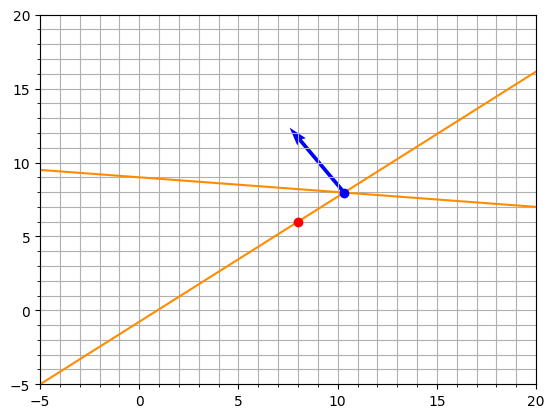

In [7]:
ax.plot(milp_sol_x, milp_sol_y, 'ro')
fig

['0,0.219512', '1,-1.056911', '>=', '-5.93496']
['1,-0.032520', '>=', '-0.227642']


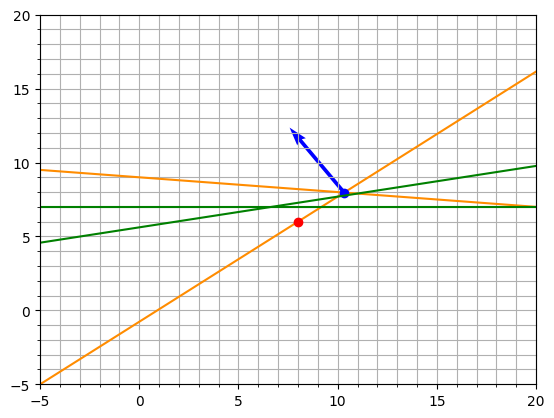

In [8]:
#building cuts
with open("files/cuts.txt", 'r') as f:
    for line in f:
        if line == "": break
        elems = line.split()
        print(elems)
        if elems[0].split(',')[0] == "1":
            rhs = float(elems[2])
            yval = float(elems[0].split(',')[1])
            xval = 0
        elif elems[1] == ">=":
            rhs = float(elems[2])
            xval = float(elems[0].split(',')[1])
            yval = 0
        else:
            xval = float(elems[0].split(',')[1])
            yval = float(elems[1].split(',')[1])
            rhs = float(elems[3])
        if yval != 0:
            x = np.array([-10 + 0.1 * i for i in range(0, 1001)])
            y = (rhs - xval * x) / yval
        else:
            y = np.array([-10 + 0.1 * i for i in range(0, 1001)])
            x = np.ones(len(y)) * rhs / xval
        ax.plot(x, y, 'green')

fig


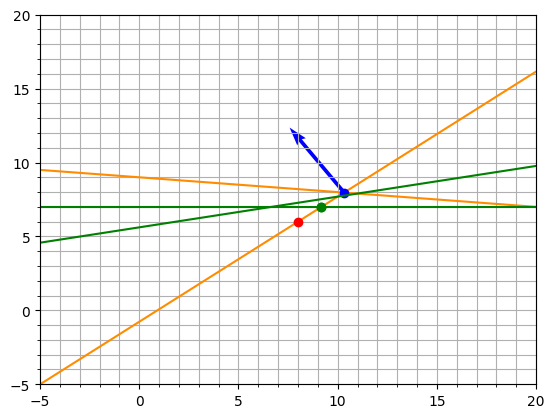

In [10]:
lp = LP()
lp.readLP(b"./files/plane_cutted.lp")
lp.solve()
x_r, y_r = lp.getPrimal()

ax.plot(x_r, y_r, 'og')

fig